# PW04 - EX2 - Group 4
* Florian Bär
* Matthias Egli
* Manuel Vogel
* Adrian Willi

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Prepare GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Loading Data

In [ ]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [ ]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [ ]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP with Dropout Regularisation

Use different dropout rates for the input layer (`p_in`) and hidden layers (`p_hidden`). 

In [ ]:
from typing import List


class MLP:

    def __new__(self, units: List[int] = [28*28, 10], dropout_input: float = 0.0, dropout_hidden: float = 0.0):
        layers = [torch.nn.Flatten()]
        layers.append(torch.nn.Dropout(p=dropout_input))
        layers.append(torch.nn.Linear(units[0], units[1]))
        layers.append(torch.nn.Sigmoid())

        if len(units) > 2:
            for i in range(1, len(units)-2):
                layers.append(torch.nn.Dropout(p=dropout_hidden))
                layers.append(torch.nn.Linear(units[i], units[i+1]))
                layers.append(torch.nn.Sigmoid())

        layers.append(torch.nn.Dropout(p=dropout_hidden))
        layers.append(torch.nn.Linear(units[-2], units[-1]))
        return torch.nn.Sequential(*layers)


In [ ]:
from torchsummary import summary
model = MLP([28*28, 200, 10], 0.0, 0.0)

model.to(device)

summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
           Sigmoid-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


### Training

Implement the training / evaluation loop

Remember and return training / validation cost and accuracy per epoch. 

In [ ]:

def train_eval(model, lr, nepochs, nbatch, training_data, validation_data):

    cost_hist, cost_hist_valid = [], []
    acc_hist, acc_hist_valid = [], []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    training_loader = DataLoader(
        training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(
        validation_data, batch_size=nbatch, shuffle=True)

    size = len(training_loader.dataset)
    nbatches = len(training_loader)
    size_valid = len(validation_loader.dataset)
    nbatches_valid = len(validation_loader)

    for epoch in range(nepochs):

        cost, acc = 0.0, 0.0
        cost_valid, acc_valid = 0.0, 0.0

        for batch, (X, Y) in enumerate(training_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            # forward
            model.train()
            yhat = model(X)
            loss = cost_ce(yhat, Y)
            cost += loss.item()
            acc += (yhat.argmax(dim=1) == Y).type(torch.float).sum().item()

            # zero the parameter gradients
            optimizer.zero_grad()

            # backprop and step
            loss.backward()
            optimizer.step()

        cost /= nbatches
        acc /= size
        cost_valid, acc_valid = 0.0, 0.0

        # validation
        model.eval()
        with torch.no_grad():
            for X, Y in validation_loader:
                X = X.to(device)
                Y = Y.to(device)
                yhat = model(X)
                cost_valid += cost_ce(yhat, Y).item()
                acc_valid += (yhat.argmax(dim=1) ==
                              Y).type(torch.float).sum().item()

        cost_valid /= nbatches_valid
        acc_valid /= size_valid

        print("Epoch %i: %f, %f, %f, %f" %
              (epoch, cost, acc, cost_valid, acc_valid))

        cost_hist.append(cost)
        cost_hist_valid.append(cost_valid)
        acc_hist.append(acc)
        acc_hist_valid.append(acc_valid)

    return cost_hist, cost_hist_valid, acc_hist, acc_hist_valid


### Analyse Different Settings

Start with a baseline model: 200 units in a single hidden layer; batch size 64; properly tuned learning rate, no dropout.

Then play with different model complexities and dropout rates and compare them on the basis of the validation set.

Estimate also the variance error by the difference between validation and training loss / accuracy.

Finally, identify a favourite combination (model complexity, dropout rate) and compute the test accuracy. 


In [ ]:
nbatch = 64
nepochs = 50
lr = 0.1

complexity = [
    [28*28, 200, 10],
    [28*28, 64, 64, 64, 64, 64, 10],
    [28*28, 128, 128, 64, 10],
    [28*28, 64, 128, 64, 10],
]

drop_p = [
    (0.0, 0.0),
    (0.8, 0.6),
    (0.8, 0.5),
    (0.8, 0.8),
]

costs = {"train": [], "test": []}
accs = {"train": [], "test": []}


for config in complexity:
    for p in drop_p:
        print("########")
        print("CONFIG: ", config, p)
        print("########")

        model = MLP(
            units=config, dropout_input=p[0], dropout_hidden=p[1])

        model.to(device)

        cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(
            model, lr, nepochs, nbatch, training_data, validation_data)

        costs["train"].append(cost_hist)
        costs["test"].append(cost_hist_test)
        accs["train"].append(acc_hist)
        accs["test"].append(acc_hist_test)


########
CONFIG:  [784, 200, 10] (0.0, 0.0)
########
Epoch 0: 0.955224, 0.677280, 0.657080, 0.754200
Epoch 1: 0.568907, 0.794660, 0.548715, 0.803100
Epoch 2: 0.503037, 0.821220, 0.586022, 0.778300
Epoch 3: 0.470985, 0.832300, 0.495080, 0.824600
Epoch 4: 0.449739, 0.841340, 0.532766, 0.799100
Epoch 5: 0.433761, 0.845040, 0.460465, 0.834700
Epoch 6: 0.421338, 0.849880, 0.459283, 0.833500
Epoch 7: 0.411421, 0.854580, 0.462804, 0.834200
Epoch 8: 0.401638, 0.856740, 0.419616, 0.849900
Epoch 9: 0.393368, 0.859980, 0.418953, 0.849200
Epoch 10: 0.386971, 0.862220, 0.431244, 0.845200
Epoch 11: 0.381592, 0.864840, 0.417487, 0.847700
Epoch 12: 0.374912, 0.866000, 0.427230, 0.846400
Epoch 13: 0.369515, 0.868560, 0.410520, 0.851000
Epoch 14: 0.364044, 0.869400, 0.422707, 0.845300
Epoch 15: 0.359219, 0.871960, 0.394130, 0.858000
Epoch 16: 0.354487, 0.873060, 0.386352, 0.861200
Epoch 17: 0.350888, 0.873960, 0.423805, 0.841600
Epoch 18: 0.347313, 0.875560, 0.377553, 0.864200
Epoch 19: 0.342974, 0.8762

### Suitable Output Plots

Possibly adjust to fit your needs...

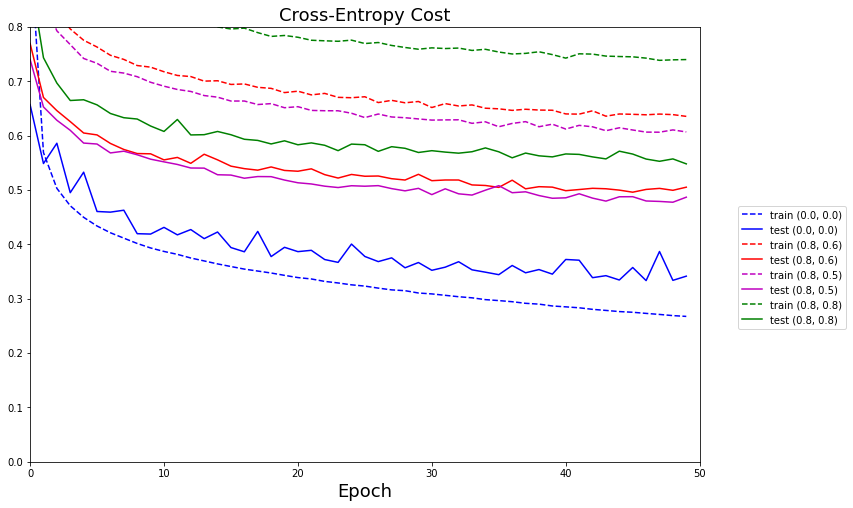

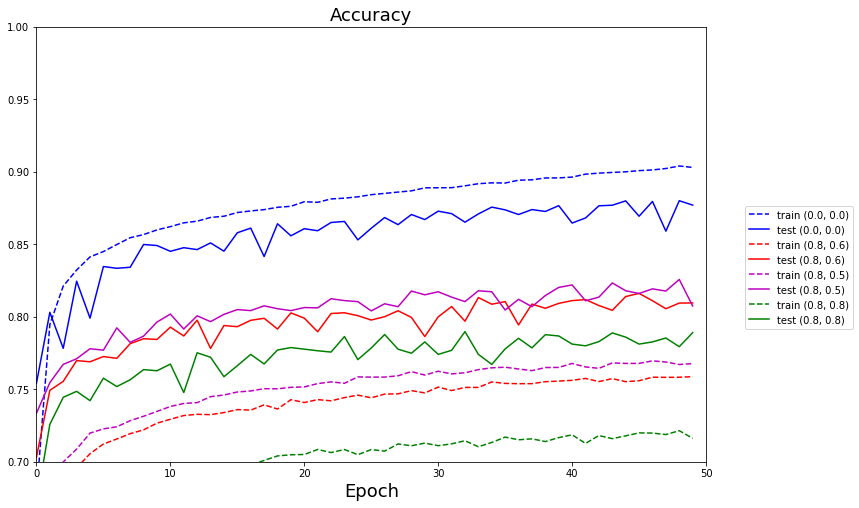

In [ ]:
colors = ["b--","r--","m--","g--","y--"]
colors_test = ["b-","r-","m-","g-","y-"]


plt.figure(1, figsize=(12,8))
for i in range(len(drop_p)):
    plt.plot(torch.arange(nepochs), costs["train"][i], colors[i], label="train "+str(drop_p[i]))
    plt.plot(torch.arange(nepochs), costs["test"][i], colors_test[i], label="test "+str(drop_p[i]))
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0,nepochs)
plt.ylim(0,0.8)
plt.title("Cross-Entropy Cost", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))
plt.figure(2, figsize=(12,8))
for i in range(len(drop_p)):
    acc = np.array(accs["train"][i])
    acc_test = np.array(accs["test"][i])
    plt.plot(torch.arange(nepochs), acc, colors[i], label="train "+str(drop_p[i]))
    plt.plot(torch.arange(nepochs), acc_test, colors_test[i], label="test "+str(drop_p[i]))
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0,nepochs)
plt.ylim(0.7,1.0)
plt.title("Accuracy", fontsize=18)
plt.legend(bbox_to_anchor = (1.05, 0.6))